# Large Language Model Visual Analytic Chat Comparison

This is a notebook that explores how different large language models produce visualizations in response to user utterances.

We use conversations from a previously published study to evaluate the model's behavior. The conversations in this prior study were broken up into chunks. Each chunk represents a sequence of utterance that are intended to modify a data visualization. Thus the conversational context needs to be maintained within a chunk, but can be different for each chunk. 

**Setup**

To run this notebook you'll need to set up a `.env` file that contains an OpenAI and Hugging Face API Keys, as well as links to different urls and assistant IDs. That's because accessing all of these tools cost money (yes even the open source ones) and so you will need to set that up. See `.env_example` for an example of what this file should look like.

**Streamlit App**

The results of this notebook are compiled into a streamlit application. To run this application, run `pipenv run app` in the terminal. A version of this application is also hosted here: TBD

In [1]:
#import generic API call library
from llm_comparison.chatgpt import call_openai
from llm_comparison.chatgpt_assistants import run_openai_assistant
from llm_comparison.hf_codellama import call_codellama, setup_codellama
from llm_comparison.cohere import cohere_query

#conversation helper functions
from llm_comparison.chat2Vis import get_primer
from llm_comparison.analytic_conversation import analytic_conversation

#data handling
import pandas as pd

#chatgpt
from openai import OpenAI

#hugging face
from huggingface_hub import InferenceClient

#cohere
import cohere

#image handling
import io
import base64
from IPython import display
import matplotlib.pyplot as plt

#misc
from dotenv import dotenv_values
import concurrent.futures
import hashlib
from random import randint
from time import sleep 
import re

/Users/ana.crisan/.local/share/virtualenvs/llm_comparison-12X0hGMe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up and test

## Set up dataset, test conversation, environment

In [2]:
# load environment variables
config = dotenv_values(".env")

#useful because your don't need to read in the CSV data, makes things a little easier
df = pd.read_csv('workspace/Titanic-Dataset.csv')

Basic conversation with a system instruction plus one user question to test that the models are working as expected

In [3]:
#primer for the converations
primer_desc, primer_code = get_primer(df,'./workspace/Titanic-Dataset.csv')

#initial system instructions
convo_hist = [
  {"role": "system", "content": primer_desc}
]

#adding an example user utterance
convo_hist.append({'role':"user", "content":"show chart of total number of people surviving vs not surviving"})

In [4]:
#primer modification to align with instructions that are given to the VA assistant I've set up with Code Interpreter
primer_mod = "You are an assistant helping a data scientist write code that produces a data visualization.  Using Python version 3.9.12, create and return a script for generating a visualization responding to the user's query. Unless the user enters a phrase like `start over', `rest' or `clear' retain the context prior the prior messages when updating the visualization. Otherwise, start a brand new data visualization."

###  Setting up/ Testing the models

In [9]:
## Open AI
oai_client = OpenAI(
    api_key=config['OPENAI_API_KEY']
)

#### Open AI Conversations API

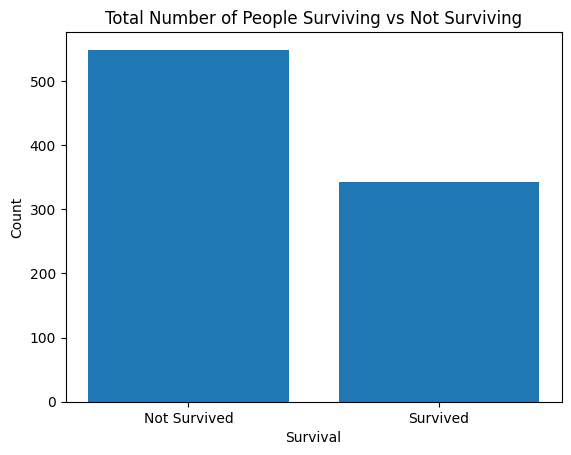

In [16]:
gpt_ans= call_openai(oai_client,messages=convo_hist)
exec(gpt_ans)

#### Open AI Assistants API

In [17]:
#initialze conversation
thread = oai_client.beta.threads.create()
a_id = config['ASSISTANT_ID']

message = {
    "role": "user",
    "content": "show chart of total number of people surviving vs not surviving"
}

code = run_openai_assistant(oai_client,
                            message,
                            thread.id,
                            a_id,
                            primer_desc,
                            config['OAI_FILE'],
                            code_only=True)

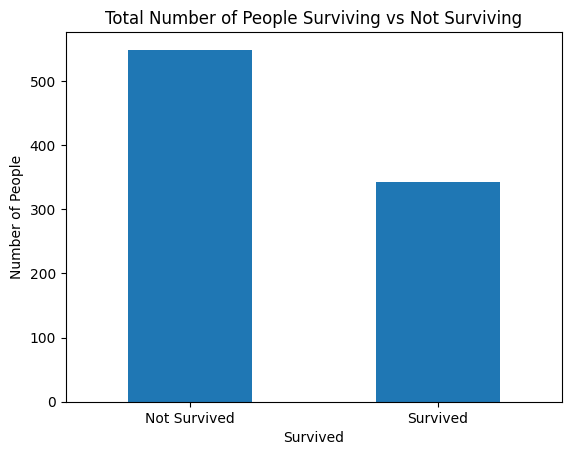

In [18]:
exec(code)

In [19]:
messages, image, run = run_openai_assistant(oai_client,
                            message,
                            thread.id,
                            a_id,
                            primer_desc,
                            config['OAI_FILE'])

ValueError: too many values to unpack (expected 3)

#### Code LLama - Hugging Face Inference Endpoint

Generally, the Code LLama 7B model performs quite poorly. But its cheaper than other types of models to get set up with. I don't generally recommend us it for any actual workloads.

The 34B version of Code Llama is much better and more expensive to run (requires are larger instance). The version I've used in the [Phind-CodeLlama-34B-v2](https://www.phind.com/blog/code-llama-beats-gpt4) version, which is a Fine-tune of the model that was released by Meta. As of this date, it is the best open source Code generation model out there, [here's a leaderboard](https://huggingface.co/spaces/bigcode/bigcode-models-leaderboard) of Open Source Models maintained by HuggingFace. Hers' [another leadeboard](https://huggingface.co/spaces/mike-ravkine/can-ai-code-results) looking at different benchmarks.

In [13]:
### Code LLAMA Set Up
hf_inf = InferenceClient(config['CL_34B'], token=config['HF_API_KEY'])

# generation parameter
gen_kwargs = dict(
        max_new_tokens=480,
        top_k=30,
        top_p=0.9,
        temperature=0.2,
        repetition_penalty=1.02,
)


In [14]:
code = call_codellama(convo_hist,hf_inf,gen_kwargs,primer_code=primer_code)


No chat template is defined for this tokenizer - using the default template for the CodeLlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



HfHubHTTPError: 502 Server Error: Bad Gateway for url: https://yw62t3k294jifv8w.us-east-1.aws.endpoints.huggingface.cloud/ (Request ID: rO4o1a)

502 Bad Gateway

In [11]:
try:
    exec(code)
except:
    print("Failed to execute code")

Failed to execute code


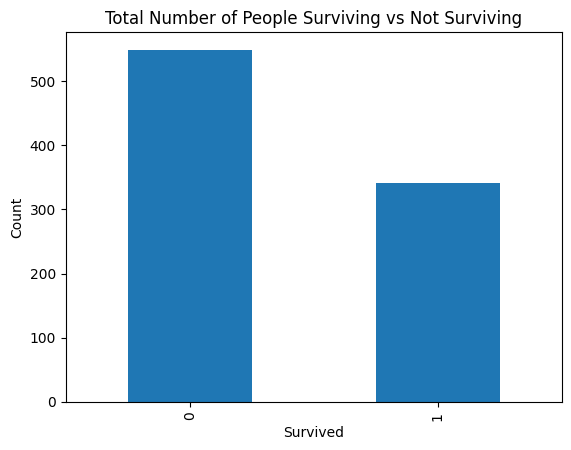

In [12]:
code_matches = re.findall(r'```python\n(.*?)\n```', code, re.DOTALL)
exec(code_matches[0])

**7B endpoint for comparison**

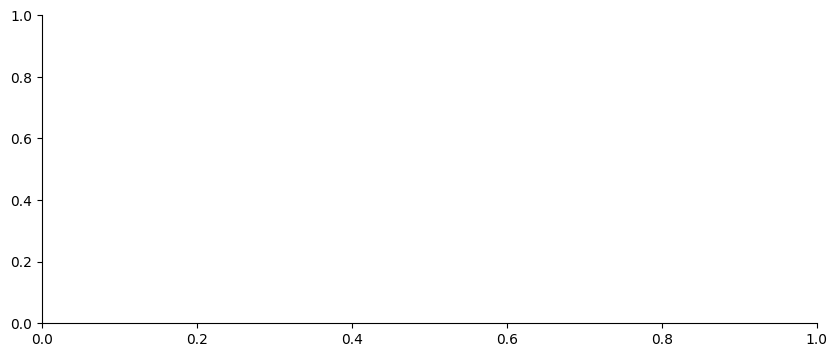

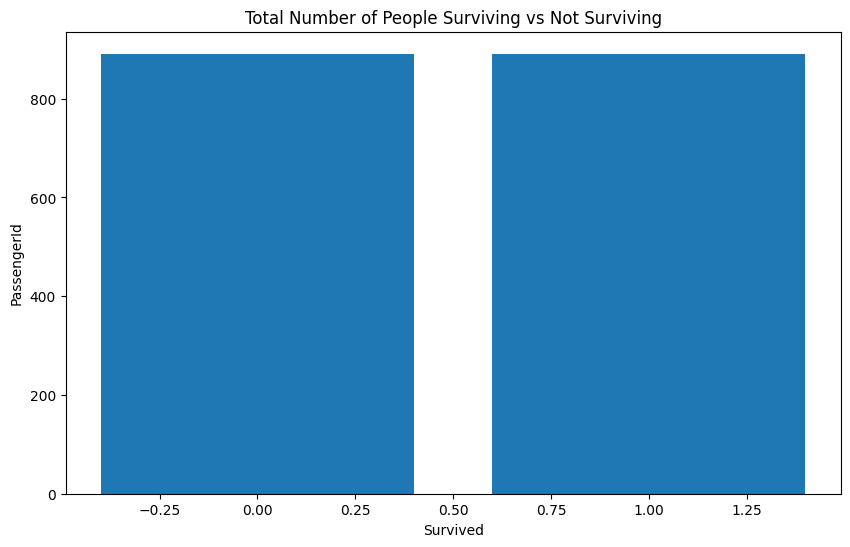

In [10]:
### Code LLAMA Set Up
hf_inf = InferenceClient(config['CL_7B'], token=config['HF_API_KEY'])

# generation parameter
gen_kwargs = dict(
        max_new_tokens=480,
        top_k=30,
        top_p=0.9,
        temperature=0.2,
        repetition_penalty=1.02,
)

code = call_codellama(convo_hist,hf_inf,gen_kwargs,primer_code=primer_code)

try:
    exec(code)
except:
    print("Failed to execute code")

#### Cohere API

This model seems to be hit or miss. It doesn't consistently produce executable code, and when it does, it has some very strange errors. It's not explicitly trained on code like Code LLama and Code-Interpreter, so its technically more similar to GPT-3.5, but its not as good.

In [13]:
co = cohere.Client(config['COHERE_API_KEY'])

preamble_override = primer_mod + "\n" + primer_desc

#message one
resp = cohere_query(co,"show chart of total number of people surviving vs not surviving",preamble_override)

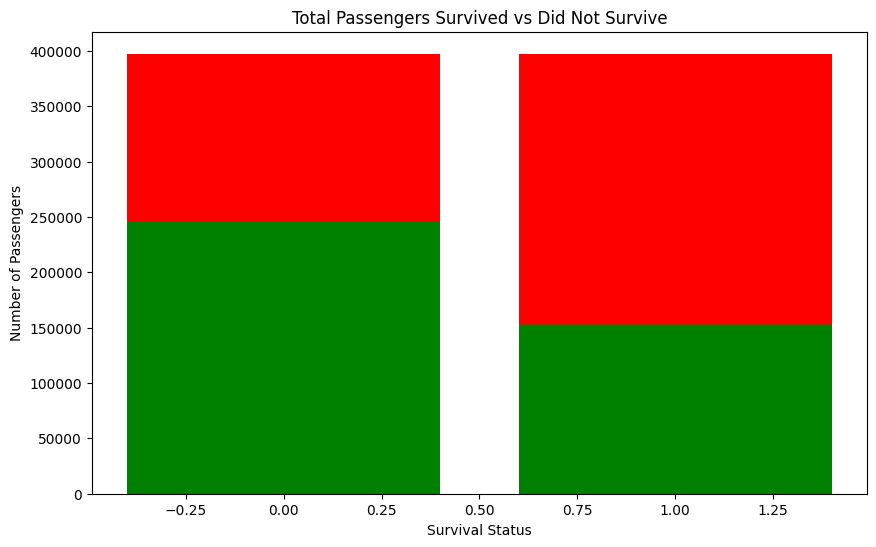

In [14]:
#often need to further process the code
code_matches = re.findall(r'```python\n(.*?)\n```', resp.text, re.DOTALL)
try:
    exec(code_matches[0])
except:
    print("Failed to execute code")

In [18]:
def filter_hist(chat_history):
    filtered = []
    for chat in chat_history:
        filtered.append({'role': chat['user_name'], 'message': chat['message']})
    
    return(filtered)

chat_history = filter_hist(resp.chat_history)


In [26]:
#add to conversation
resp = cohere_query(co,"break this down by gender",preamble_override,chat_history=chat_history)

In [27]:
resp.chat_history

[{'user_name': 'User',
  'text': 'How many people survived?',
  'message': 'How many people survived?',
  'active': False,
  'role': 'User'},
 {'user_name': 'Chatbot',
  'text': 'Of the people represented in the data frame, 1307 people survived. This is represented in the `Survived` column in the dataset, which contains the numerical value `1` for those who survived the Titanic shipwreck, and `0` for those who did not. You can use the following code to calculate the number of survivors:\n```python\ntotal_rows = df.shape[0]\nsurvivors = df[df[\'Survived\'] == 1].shape[0]\n\nprint(f"Total people in the dataset: {total_rows}")\nprint(f"Total survivors: {survivors}")\n``` \n\nThis code uses the pandas `shape` method to determine the number of rows in the DataFrame and then filters the DataFrame to only include rows where the \'Survived\' column is equal to `1`, which represents individuals who survived the Titanic shipwreck. It then uses the `shape` method again to determine the number of 

# Run on WoZ Study Utterances

In [7]:
convos = pd.read_csv('workspace/utterances.csv')

add a has id to the utterances to make it easier to follow


In [8]:
def get_hash(x):
    ''' Assign a has to the utterances'''
    rn = str(randint(0, 100))
    return(hashlib.md5(f"{x['PID']}-{x['Utterance']}-{rn}".encode('utf-8')).hexdigest())


pids = convos['PID'].unique()

convos['utt_id']=convos.apply(lambda x: get_hash(x), axis=1)


Run the model. Note, you can do this in a loop, but I've run each participant one at time. Otherwise, I run into issues of potential pinging the API too much and getting errors. For GPT-4 in particular, its more common for the API to fail during peak times, GPT-3 is more stable.

In [11]:
#set up
sys={"role": "system", "model":'',"content": primer_mod + "\n" + primer_desc}
a_id = config['ASSISTANT_ID']

#which models to run
#run_models = ['GPT-4','GPT-3','CodeLlama','Cohere']
run_models = ['CodeLlama']

#filter conversation
for pid in ['P03']: 
    #set up the chat history for cohere models
    # could also pass just the conversation id
    if 'Cohere' in run_models:
        chat_history = []

    #utterance only for this participant
    sub_convo = convos[convos['PID']==pid]

    #new analytic conversation object for participant
    new_convo = analytic_conversation(pid,[sys])

    #For Code Interpreter : initialze conversation - for each participant
    thread = oai_client.beta.threads.create()

    grouped = sub_convo.groupby('Chunk')

    for chunk, group in grouped:
        for utt,utt_id in group[['Utterance','utt_id']].values.tolist():       
            #add new utterance
            new_convo.add_utterance(utt,utt_id)

            responses = {}
            #get language model results
            with concurrent.futures.ThreadPoolExecutor() as executor:
                    #%%%%%%%%%%
                    # Code Interpreter / GPT-4
                    #%%%%%%%%%%
                    if 'GPT-4' in run_models:
                        future1 = executor.submit(run_openai_assistant,
                                                  oai_client,
                                                  {'role':'user', 'content':utt},
                                                  thread.id,
                                                  a_id,
                                                  primer_desc,
                                                  config['OAI_FILE']) 
                       
                        CI_ans = future1.result()
                        
                        if type(CI_ans) not in [tuple,str]:
                            break
                        
                        #when its a text response, modify what is returned
                        if type(CI_ans) == tuple:
                            try:
                                CI_ans = f"TEXT:{CI_ans[0].data[0].content[0].text.value}"
                            except:
                                print("Returned and image for some reason")
                                CI_ans == f"IMAGE:"

                        responses['CI']=CI_ans

                    #%%%%%%%%%%
                    # GPT-3
                    #%%%%%%%%%%
                    if 'GPT-3' in run_models:
                        future2 = executor.submit(call_openai, 
                                                  oai_client,
                                                  'gpt-3.5-turbo',
                                                  new_convo.return_filtered_history('gpt3'))
                        try:
                            gpt_ans = future2.result()
                        except:
                            gpt_ans="FAILED TO RUN"

                        responses['gpt3']=gpt_ans

                    #%%%%%%%%%%
                    # Code Llama
                    #%%%%%%%%%%
                    if 'CodeLlama' in run_models:
                        
                        #truncate the history
                        tmp = new_convo.return_filtered_history('cl')
                        total_len = len(tmp)

                        if(total_len > 6):
                            tmp = [tmp[0]] + tmp[len(tmp)-3:len(tmp)]

                        #run the model
                        future3 = executor.submit(call_codellama, 
                                                  tmp,
                                                  hf_inf,
                                                  gen_kwargs)
                        try:
                            cl_ans = future3.result()
                            #cl_ans = re.findall(r'```python\n(.*?)\n```', cl_ans.text, re.DOTALL)[0]
                        except:      
                            cl_ans="FAILED TO RUN"
                        responses['cl']=cl_ans

                    #%%%%%%%%%%
                    # Cohere
                    #%%%%%%%%%%
                    
                    if 'Cohere' in run_models:
                        future4 = executor.submit(cohere_query, 
                                                  co,
                                                  utt,
                                                  preamble_override,
                                                  chat_history=chat_history
                        )
                        try:
                            co_ans = future4.result()
                        except:
                            co_ans="FAILED TO RUN"
                        
                        #process the cohere answer a little bit more
                        chat_history = filter_hist(co_ans.chat_history)
                        co_ans = re.findall(r'```python\n(.*?)\n```', co_ans.text, re.DOTALL)[0]
                        responses['cohere']=co_ans


            #add responses to conversation history
            new_convo.add_response(utt_id,responses)
            
            sleep(5) #avoid over pinging the API


    all_df = pd.merge(sub_convo,new_convo.to_df(),on='utt_id',how='inner')

    #this is useful for editing mistakes in the streamlit app
    all_df['revised'] = all_df['content']
   

In [12]:
all_df

,PID,Context Shift,Anaphoric Reference,Utterance,Chunk,utt_id,role,model,content,revised
0,P03,Explicit,No,How many people survived?,1,84bba3b5ef69e8bccb34ca9151d83716,user,,How many people survived?,How many people survived?
1,P03,Explicit,No,How many people survived?,1,84bba3b5ef69e8bccb34ca9151d83716,assistant,cl,```\nimport pandas as pd\nimport matplotlib.py...,```\nimport pandas as pd\nimport matplotlib.py...
2,P03,Explicit,No,Show age bins,1,245388ced8dcb372144aa205f2ffa1b5,user,,Show age bins,Show age bins
3,P03,Explicit,No,Show age bins,1,245388ced8dcb372144aa205f2ffa1b5,assistant,cl,Sure! Here's an updated version of the code th...,Sure! Here's an updated version of the code th...
4,P03,Explicit,No,What are the top 5 age bins that survived?,1,4b16acaf32e30af31b205c71b61c9a2a,user,,What are the top 5 age bins that survived?,What are the top 5 age bins that survived?
5,P03,Explicit,No,What are the top 5 age bins that survived?,1,4b16acaf32e30af31b205c71b61c9a2a,assistant,cl,"To find the top 5 age bins that survived, we c...","To find the top 5 age bins that survived, we c..."
6,P03,Explicit,No,color survived by class,1,ae9bfb2b01ba268ef6069d65fc41e86e,user,,color survived by class,color survived by class
7,P03,Explicit,No,color survived by class,1,ae9bfb2b01ba268ef6069d65fc41e86e,assistant,cl,"To color the survived by class, you can use th...","To color the survived by class, you can use th..."
8,P03,Explicit,No,show only female,1,db145f3891f7af8fa4e6d6319a69bce8,user,,show only female,show only female
9,P03,Explicit,No,show only female,1,db145f3891f7af8fa4e6d6319a69bce8,assistant,cl,"Sure, here's an updated version of the code th...","Sure, here's an updated version of the code th..."


In [21]:
all_df.to_pickle(f'workspace/convos/{pid}_analytic_convo.pkl')

In [31]:
future3.result()

"import pandas as pd\nimport matplotlib.pyplot as plt\nfig,ax = plt.subplots(1,1,figsize=(10,4))\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False) \nimport matplotlib.pyplot as plt\n\n# Create a bar plot of the survival rate by class\nplt.bar(df['Survived'], df['Pclass'])\nplt.xlabel('Survived')\nplt.ylabel('Pclass')\nplt.title('Survival Rate by Class')\nplt.show()\n\n# Create a bar plot of the survival rate by sex\nplt.bar(df['Survived'], df['Sex'])\nplt.xlabel('Survived')\nplt.ylabel('Sex')\nplt.title('Survival Rate by Sex')\nplt.show()\n\n# Create a bar plot of the survival rate by age\nplt.bar(df['Survived'], df['Age'])\nplt.xlabel('Survived')\nplt.ylabel('Age')\nplt.title('Survival Rate by Age')\nplt.show()\n\n# Create a bar plot of the survival rate by fare\nplt.bar(df['Survived'], df['Fare'])\nplt.xlabel('Survived')\nplt.ylabel('Fare')\nplt.title('Survival Rate by Fare')\nplt.show()\n\n# Create a bar plot of the survival rate by embarked\nplt.bar(df['Su

# Hacking / Playground

In [7]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot a count plot with Parch (number of parents/children aboard) as hue and survival as the x-axis
sns.histplot(data=df, x='Survived', hue='Parch', multiple='stack', shrink=0.8, palette='tab10')

# Customize plot
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Count by Number of Parents/Children Aboard')
plt.xticks(ticks=[0, 1], labels=['Did Not Survive', 'Survived'])
plt.legend(title='Parents/Children')

# Show the plot
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>